I have the clean data from the previous step that includes: <br>
- DATE: in datetime format <br>
- PRCP: water equivalent (in) or precipitation (if all the snow was melted down to water) <br>
- SNOW: new snow measured in inches <br>
- SNWD: snow depth measured in inches <br>
- TMAX: max temperature observed on that day <br>
- TMIN: min temperature observed on that day <br>
- TOBS: official observed tempterature observed on that day <br>
- MONTH: month separated from Date to make groupby easier <br>
- DAY: day separated from Date to make groupby easier <br>
- PDO: pacific decadal oscillation; data given by the month but interpolated to the day <br>
- AMO: atlantic decadal oscillation; data measure by the month but interpolated to the day <br>

In [63]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [2]:
import pickle
path="C:\Springboard\Github\Capstone1_alta\intermediate_data"
os.chdir(path)

In [3]:
ALTA = pickle.load(open("alta_snow_clean2.pkl", "rb"))
ALTA.head()

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO
0,1944-11-21,0.00,0.0,20.0,52.0,9.0,20.0,11,21,0.2,0.272
1,1944-11-22,0.00,0.0,19.0,48.0,19.0,29.0,11,22,0.2,0.272
2,1944-11-23,0.00,0.0,19.0,56.0,24.0,40.0,11,23,0.2,0.272
3,1944-11-24,0.82,6.0,25.0,52.0,14.0,16.0,11,24,0.2,0.272
4,1944-11-25,0.06,11.0,36.0,26.0,11.0,14.0,11,25,0.2,0.272


This data looks just like how I left it; now, let's see if I can gather some stats on the different values

In [4]:
ALTA.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO
count,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21200.000000,21808.000000
mean,0.154552,1.501756,39.350956,46.094742,27.220721,36.997859,0.009221,0.003105
std,0.357696,3.661164,41.374939,17.692602,15.550385,18.270581,1.090899,0.216529
min,0.000000,0.000000,0.000000,-8.000000,-26.000000,-18.000000,-3.600000,-0.527000
25%,0.000000,0.000000,0.000000,32.000000,16.000000,23.000000,-0.783903,-0.152215
50%,0.000000,0.000000,26.000000,44.000000,26.000000,34.000000,0.050000,0.010298
75%,0.120000,0.500000,74.000000,62.000000,40.000000,51.000000,0.752903,0.158827
max,5.000000,38.000000,179.000000,113.000000,77.000000,84.000000,3.510000,0.519000


These values look good, but there are a few things that stand out to me: <br>
Snowfall max - 38in in a 24hrs is a lot, but it's very possible at Alta; since I focus on predicting this catagory, I need to leave this in <br>
Tmax - this max value of 113 seems extremely high for the town of Alta. I will need to plot this to see how it looks on a scatter. My instinct says this is a measurement error. <br>
All of the other values seem good.

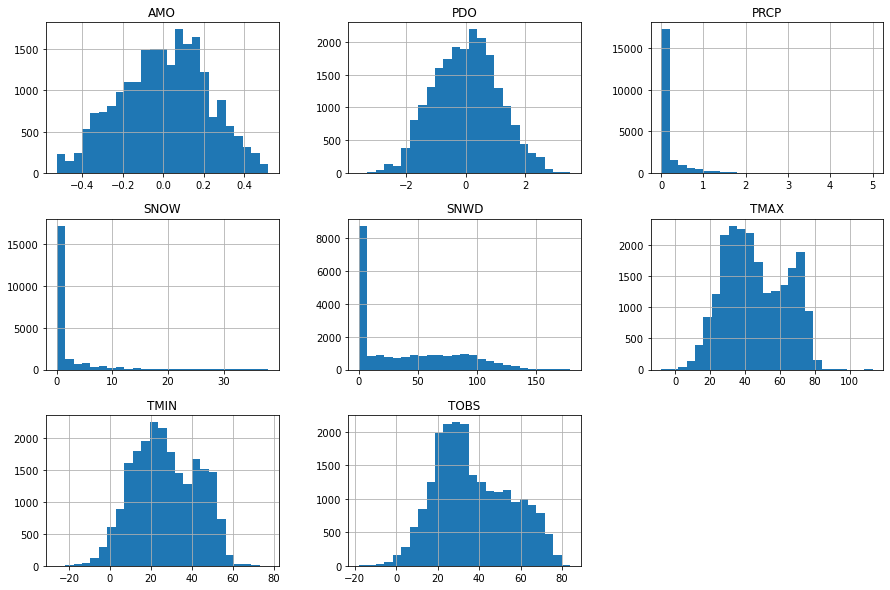

In [5]:
hist = ALTA.hist(bins=25, figsize=(15,10))

This does include summertime data, so there will be a lot of 0's for snowfall and snow depth. Even for winter, I expect a lot of days of 0 snowfall with some deep days in there. <br>
Snowfall (our variable of interest) looks like it has an exponential distribution. <br> 
Let's also compute a rolling sum of the snowfall to see if that brings about a better distribution; we will do that for both 14 and 7 days.

In [6]:
ALTA["SNOW7"] = ALTA.rolling(window=7)['SNOW'].sum()
ALTA["SNOW14"] = ALTA.rolling(window=14)['SNOW'].sum()
# a 30-day index would also be good to plot versus PDO and AMO, since those change more long-term
ALTA["SNOW30"] = ALTA.rolling(window=30)['SNOW'].sum()

In [7]:
ALTA.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
count,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21200.000000,21808.000000,2.180300e+04,2.179600e+04,2.178000e+04
mean,0.154552,1.501756,39.350956,46.094742,27.220721,36.997859,0.009221,0.003105,1.051335e+01,2.102880e+01,4.508577e+01
std,0.357696,3.661164,41.374939,17.692602,15.550385,18.270581,1.090899,0.216529,1.425929e+01,2.345198e+01,4.231070e+01
min,0.000000,0.000000,0.000000,-8.000000,-26.000000,-18.000000,-3.600000,-0.527000,-4.440892e-14,-7.105427e-14,-2.016165e-13
25%,0.000000,0.000000,0.000000,32.000000,16.000000,23.000000,-0.783903,-0.152215,-2.037259e-14,-1.265654e-14,2.500000e+00
50%,0.000000,0.000000,26.000000,44.000000,26.000000,34.000000,0.050000,0.010298,4.000000e+00,1.400000e+01,3.920000e+01
75%,0.120000,0.500000,74.000000,62.000000,40.000000,51.000000,0.752903,0.158827,1.700000e+01,3.450000e+01,7.300000e+01
max,5.000000,38.000000,179.000000,113.000000,77.000000,84.000000,3.510000,0.519000,9.900000e+01,1.540000e+02,2.675000e+02


This has me so stoked to see the median of 4 inches for 7-day sum. That includes summer! <br>
Let's separate winter and look at the histograms again.

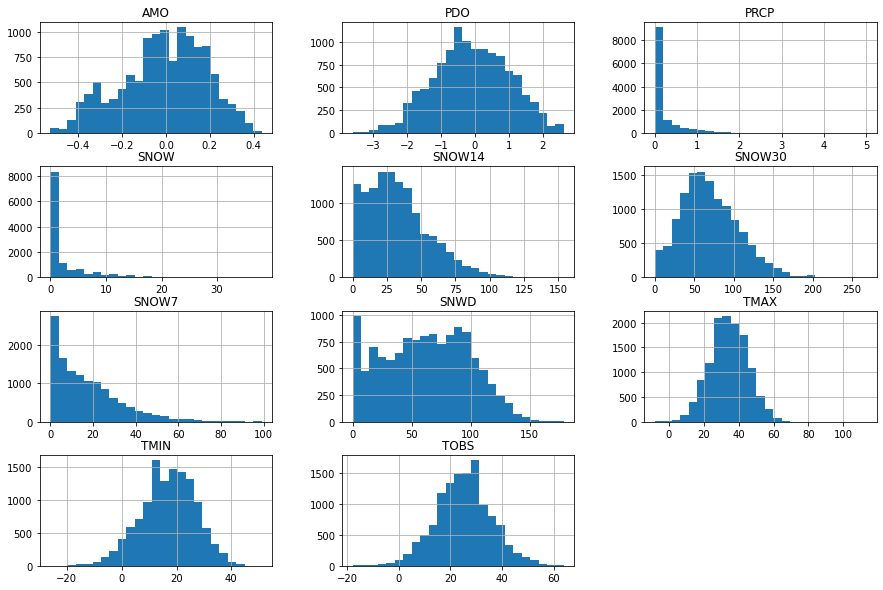

In [8]:
win = ALTA[ALTA.MONTH.isin(['11','12','01','02','03','04'])]
hist = win.hist(bins=25, figsize=(15,10))

In [9]:
win_d = win.groupby(['MONTH','DAY']).mean()

In [10]:
win_d.head()

PRCP      SNOW       SNWD       TMAX       TMIN       TOBS  \
MONTH DAY                                                                   
01    01   0.163836  2.161644  54.890411  28.860108  10.942300  19.413450   
      02   0.250000  3.121918  55.876712  29.277778  11.430556  18.378788   
      03   0.172877  2.175342  55.671233  28.992295  10.841610  18.665668   
      04   0.086849  1.608219  54.315068  28.997302  11.871316  18.742632   
      05   0.213944  2.633803  55.971831  29.694762  11.117077  19.445863   

                PDO       AMO      SNOW7     SNOW14     SNOW30  
MONTH DAY                                                       
01    01  -0.185379 -0.016918  16.894521  35.610959  74.583562  
      02  -0.184516 -0.017774  16.830137  36.554795  75.595890  
      03  -0.183653 -0.018630  16.565753  36.535616  75.363014  
      04  -0.182790 -0.019486  15.939726  35.443836  74.824658  
      05  -0.177798 -0.020946  16.178873  34.160563  74.535211

This is very cool to see. Can we plot it?

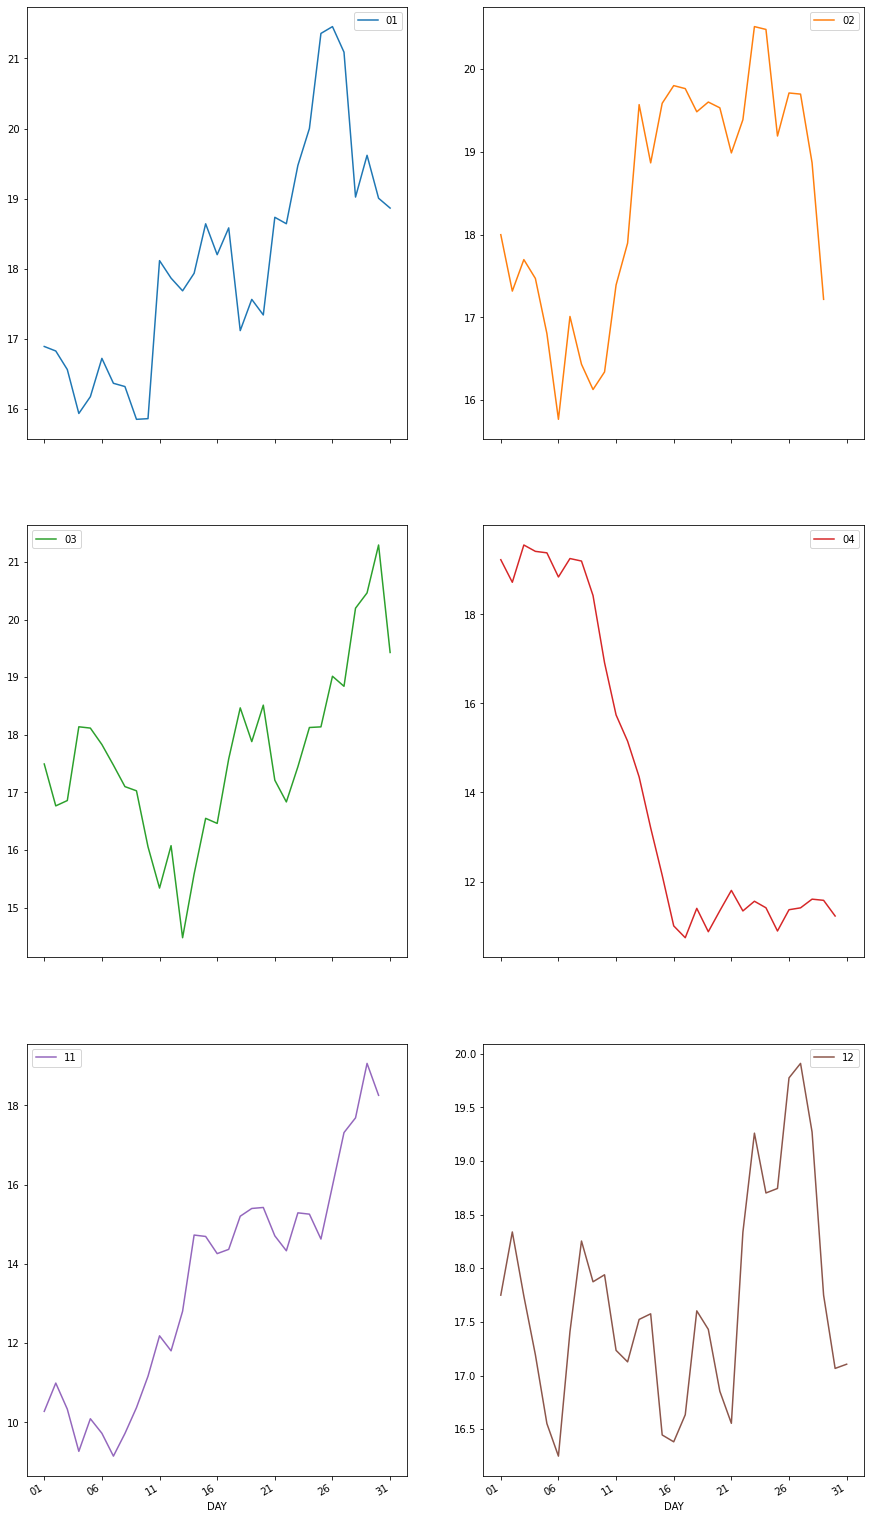

In [11]:
# plot for 7 day snowfall
# https://www.quantopian.com/posts/plotting-multi-index-pandas-dataframe
win_d.SNOW7.unstack(level=0).plot(subplots=True, figsize=(15, 30), layout=(3, 2));

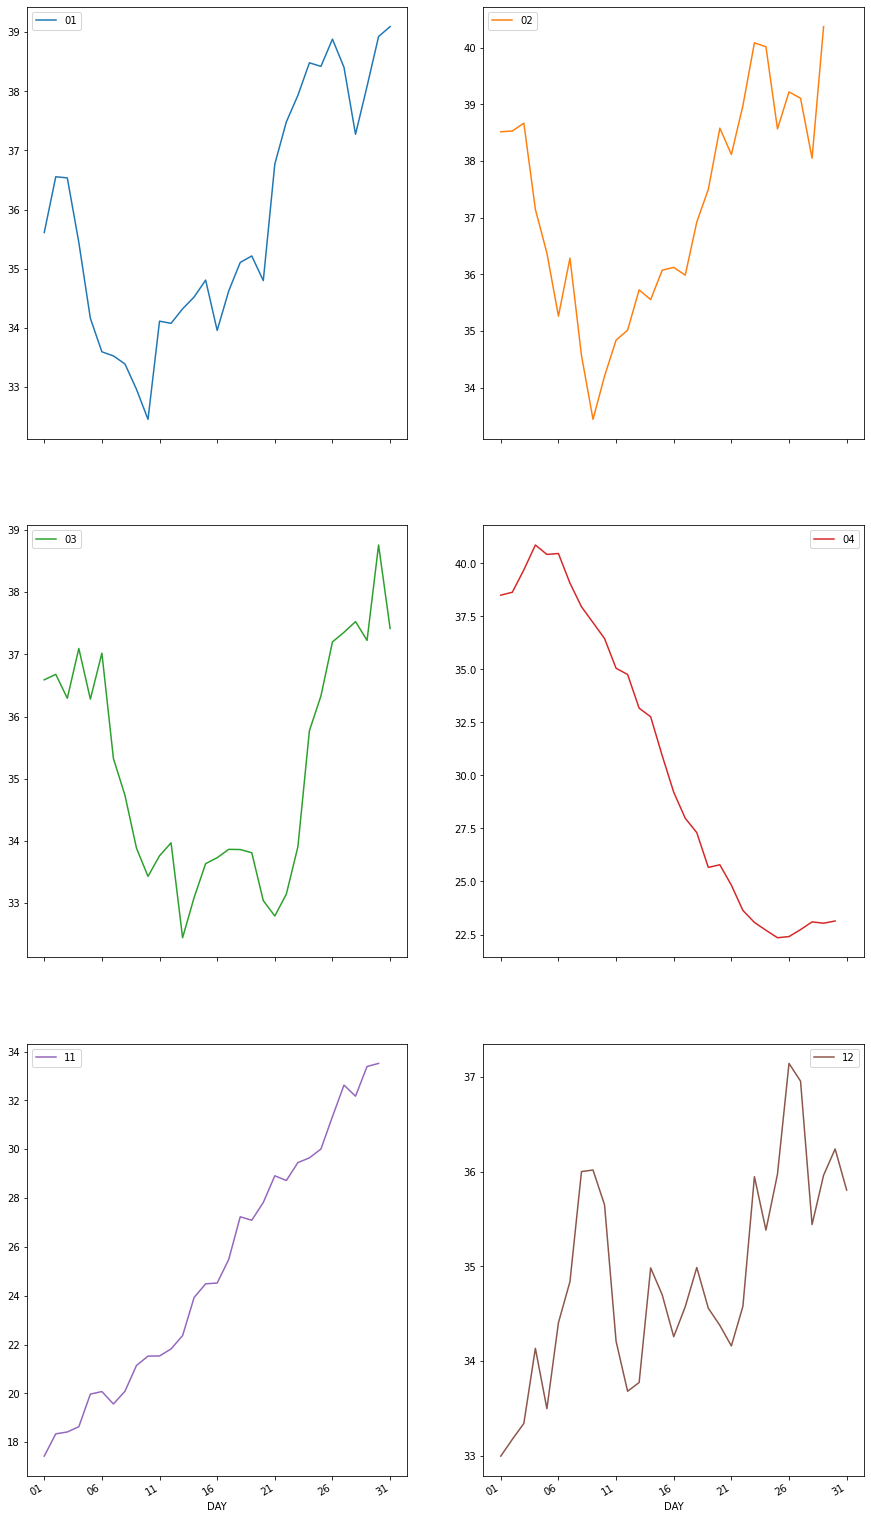

In [12]:
# those were OK, but I would really like to see the season in one continuous stretch; let's looks at longer stretches
# 14 day snowfall
win_d.SNOW14.unstack(level=0).plot(subplots=True, figsize=(15, 30), layout=(3, 2));

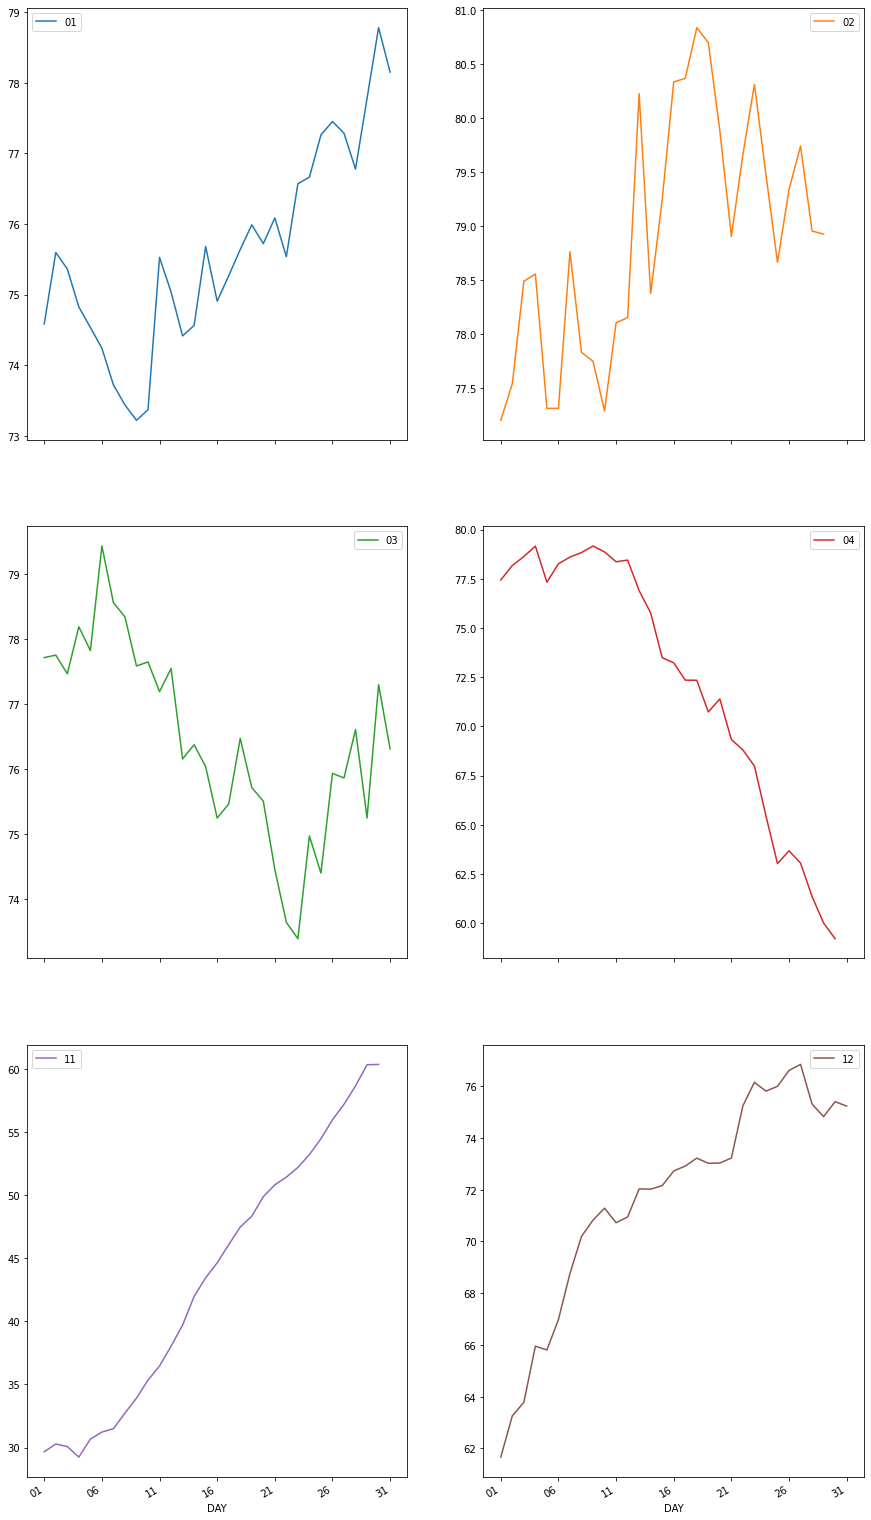

In [13]:
# those were OK, but I would really like to see the season in one continuous stretch; let's try to resort
#plt.plot(x=win_d['MONTH','DAY'], y=win_d['SNOW7']) layout=(10, 2)
# https://www.quantopian.com/posts/plotting-multi-index-pandas-dataframe
win_d.SNOW30.unstack(level=0).plot(subplots=True, figsize=(15, 30), layout=(3, 2));

In [15]:
#win_m = win.groupby(['MONTH','DAY']).median()
win_m = win.groupby(['MONTH','DAY']).median()

In [16]:
win_m.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,0.003049,0.082418,63.447802,34.568203,17.799813,25.404485,-0.116752,0.001959,12.994505,29.434890,64.781044
std,0.014031,0.279984,28.684342,4.602799,4.068001,4.758812,0.111889,0.016369,3.239108,5.512074,12.526245
min,0.000000,0.000000,3.000000,28.000000,11.000000,18.303279,-0.322857,-0.025968,4.950000,13.000000,24.600000
25%,0.000000,0.000000,40.000000,31.000000,15.000000,21.736595,-0.205887,-0.012237,11.500000,27.000000,63.262500
50%,0.000000,0.000000,74.000000,33.000000,16.750000,23.966667,-0.140752,0.001980,13.500000,30.700000,69.500000
75%,0.000000,0.000000,89.000000,38.000000,20.875000,28.851575,-0.034879,0.008622,15.087500,33.287500,73.000000
max,0.120000,1.600000,97.500000,45.160000,27.625000,37.000000,0.130000,0.036522,18.500000,38.000000,78.000000


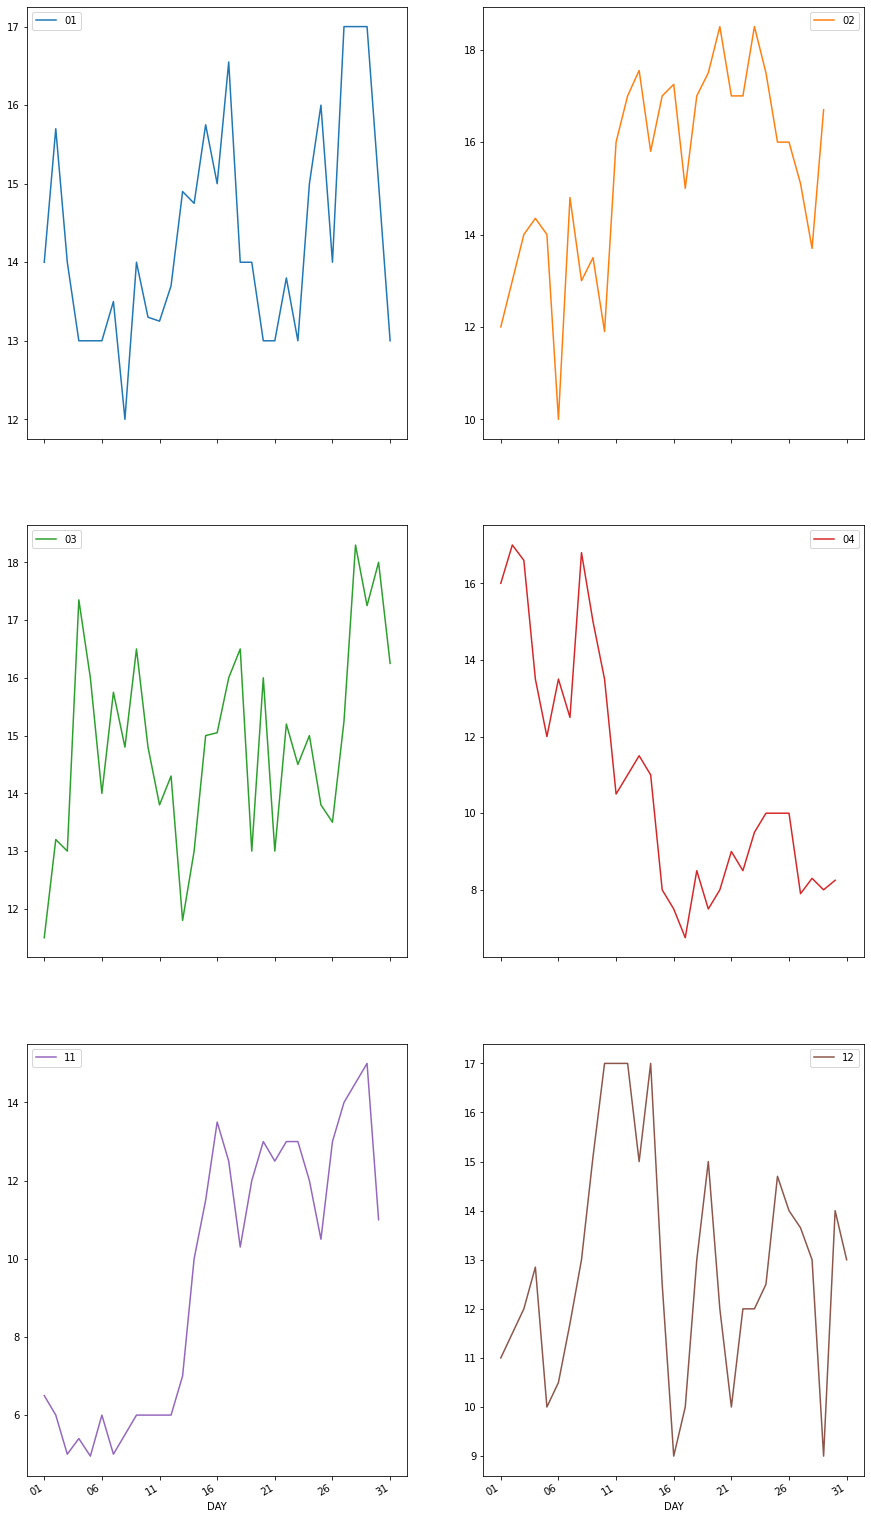

In [17]:
# These stats look far less influenced by outliers. Let's she how the plot looks
win_m.SNOW7.unstack(level=0).plot(subplots=True, figsize=(15, 30), layout=(3, 2));

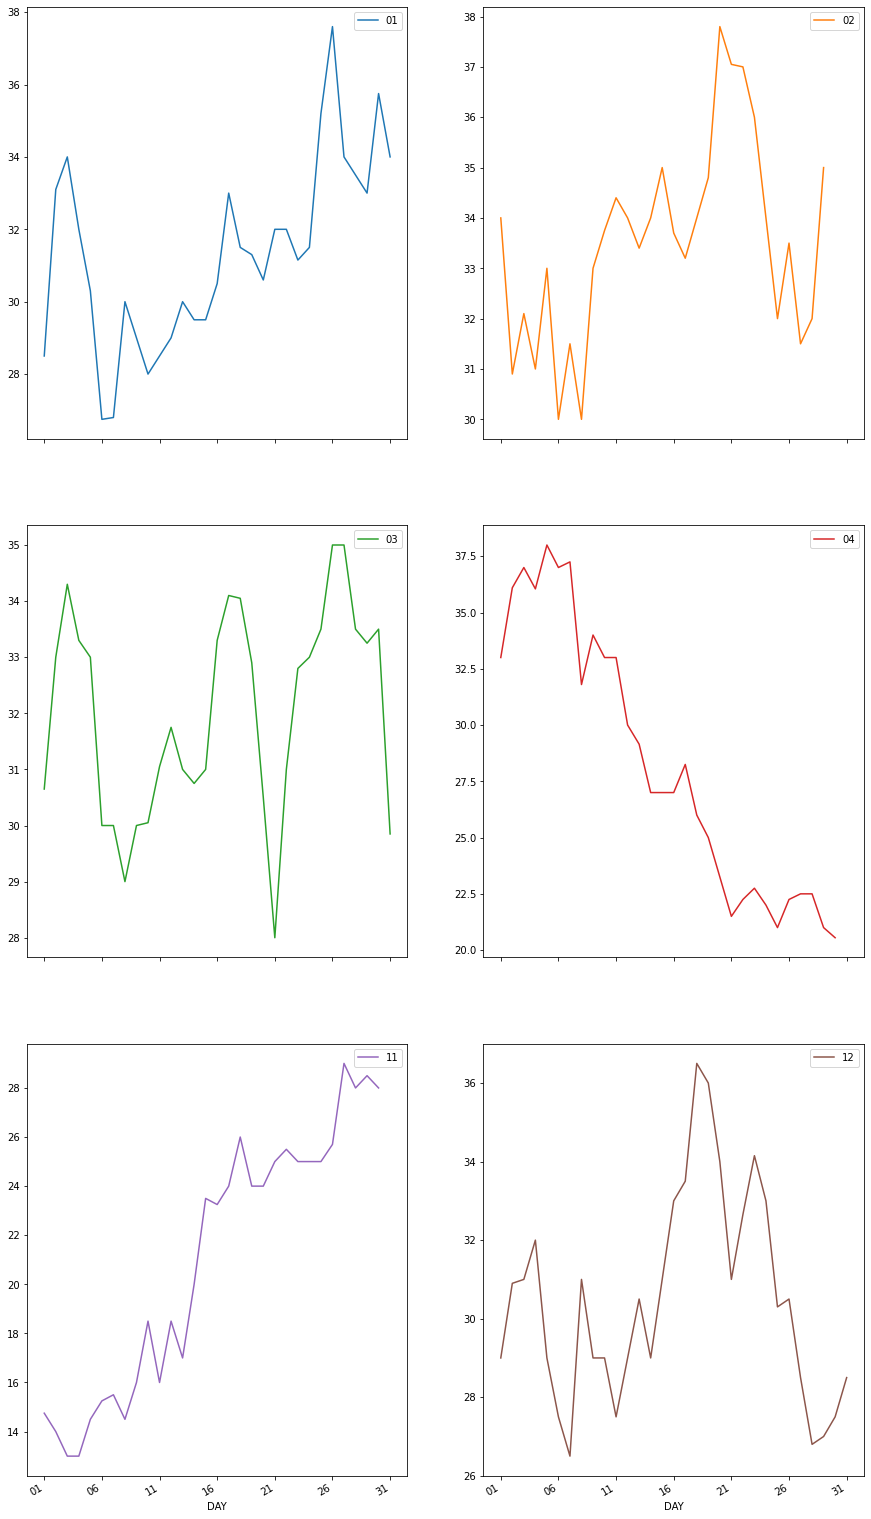

In [18]:
# These stats look far less influenced by outliers. Let's she how the plot looks
win_m.SNOW14.unstack(level=0).plot(subplots=True, figsize=(15, 30), layout=(3, 2));

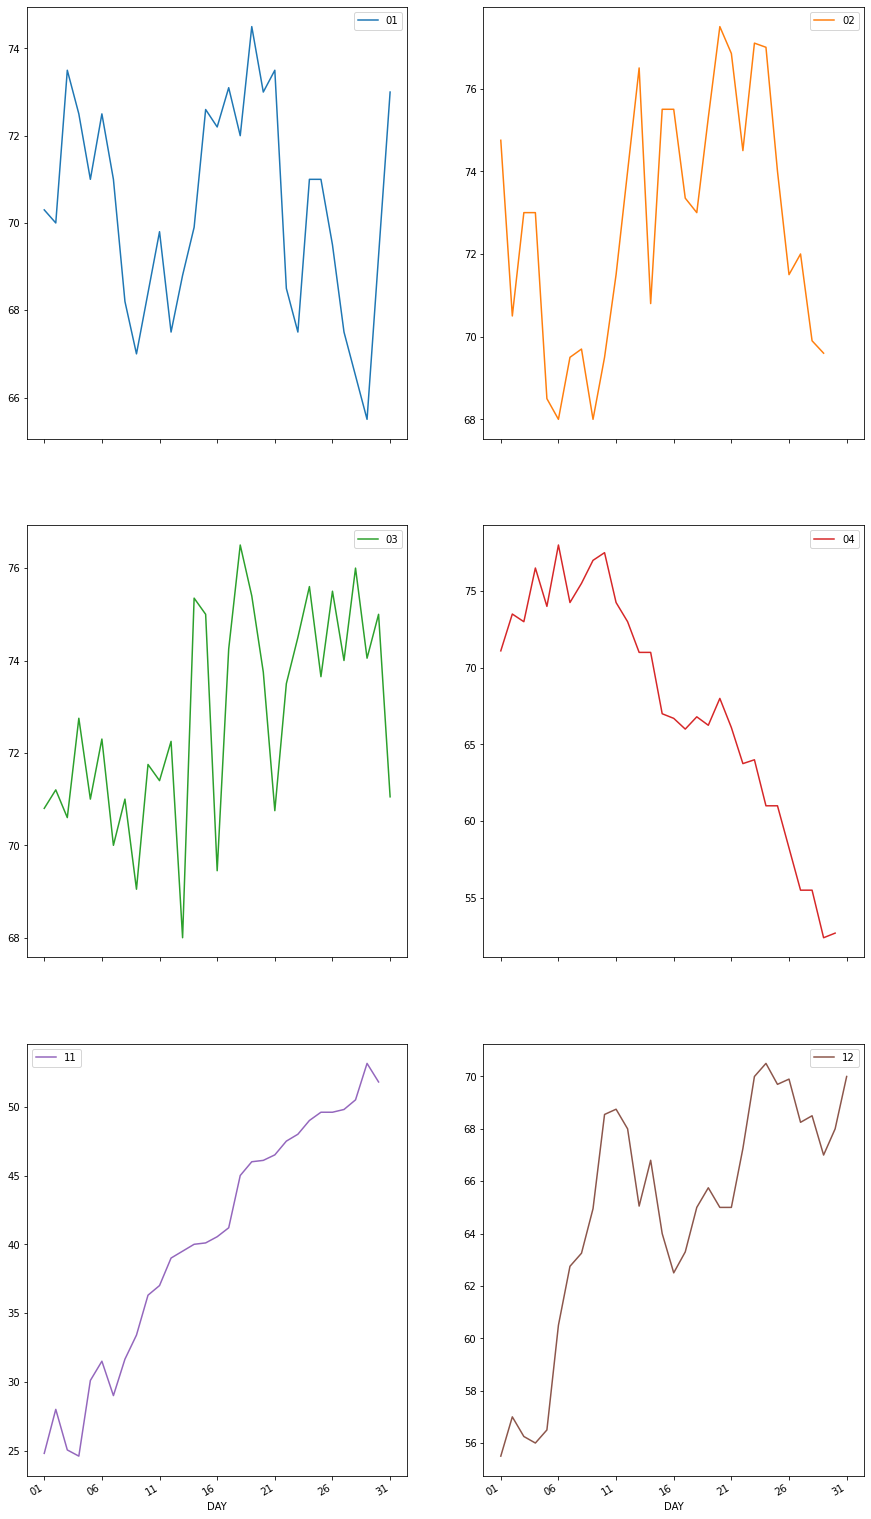

In [19]:
# These stats look far less influenced by outliers. Let's she how the plot looks
win_m.SNOW30.unstack(level=0).plot(subplots=True, figsize=(15, 30), layout=(3, 2));

There appears to be some trends throughout the season. I will try to plot this better so we could tease out some more elements from it. I need to move on to PDO and AMO to see if they have any effect on snowfall.

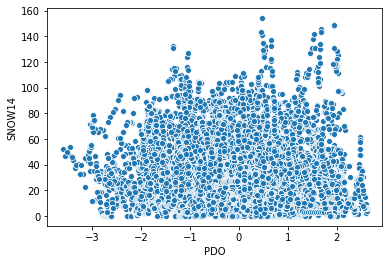

In [24]:
# Let's start with a scatter of snow for 14 days out
sns.scatterplot(win['PDO'], win['SNOW14'])
plt.show()

This doesn't appear to have a clear trend, but we are just scratching the surface. Let's try the 30-day total.

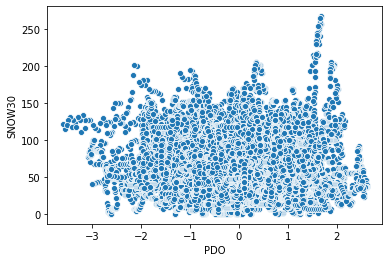

In [26]:
# Let's start with a scatter of snow for 14 days out
sns.scatterplot(win['PDO'], win['SNOW30'])
plt.show()

There appears to be some more large snow months when PDO is between 1.5 and 2. To do that, we'll put the items into buckets so we can take mean and median of PDO values that are similar.

In [31]:
buckets = np.linspace(-4, 3, 14)
win['PDOb'] = pd.cut(win['PDO'], buckets)

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
win_pdo = win.groupby(['PDOb']).median()

In [36]:
win_pdo

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
PDOb,,,,,,,,,,,
"(-4.0, -3.462]",0.00,0.0,103.0,20.5,-4.5,9.000000,-3.527926,0.158661,27.00,49.25,121.00
"(-3.462, -2.923]",0.05,2.0,43.5,28.5,9.0,17.500000,-3.039429,0.326500,23.25,45.75,96.50
"(-2.923, -2.385]",0.00,0.0,83.5,30.5,12.0,20.700000,-2.626774,0.141968,8.00,25.75,59.00
"(-2.385, -1.846]",0.00,0.0,57.0,33.0,16.0,24.000000,-1.976290,-0.061236,13.60,29.75,66.25
"(-1.846, -1.308]",0.00,0.0,69.0,33.0,15.0,22.923077,-1.575333,-0.063000,15.00,31.00,65.70
"(-1.308, -0.769]",0.00,0.0,72.0,34.0,18.0,25.000000,-0.986290,-0.002392,13.00,32.00,70.00
"(-0.769, -0.231]",0.00,0.0,70.0,34.0,17.0,25.000000,-0.472581,0.057214,14.00,30.30,66.20
"(-0.231, 0.308]",0.00,0.0,49.0,34.0,18.0,25.000000,0.042903,0.044400,13.00,28.00,63.00
"(0.308, 0.846]",0.00,0.0,58.0,34.0,19.0,26.000000,0.574516,-0.000194,13.00,29.50,70.00


In [34]:
win_pdo.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.003846,0.153846,64.500000,32.576923,15.423077,23.586391,-0.481199,0.052520,14.296154,31.411538,69.684615
std,0.013868,0.554700,15.836403,4.227125,6.981661,5.510035,2.000338,0.117080,5.331372,7.631299,19.306221
min,0.000000,0.000000,43.500000,20.500000,-4.500000,9.000000,-3.527926,-0.063000,7.500000,21.550000,48.750000
25%,0.000000,0.000000,55.000000,33.000000,15.000000,22.923077,-1.976290,-0.049200,13.000000,28.000000,61.000000
50%,0.000000,0.000000,58.000000,34.000000,18.000000,25.000000,-0.472581,0.014984,13.000000,29.500000,66.200000
75%,0.000000,0.000000,70.000000,34.000000,19.000000,26.000000,1.110323,0.141968,14.000000,31.000000,70.000000
max,0.050000,2.000000,103.000000,37.000000,22.000000,31.500000,2.505000,0.326500,27.000000,49.250000,121.000000


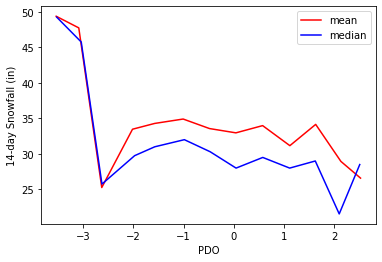

In [43]:
# let's plot that 14-day snowfall for both the median and mean
win_pdom = win.groupby(['PDOb']).mean()
plt.plot(win_pdom['PDO'], win_pdom['SNOW14'], color='red', label='mean')
plt.plot(win_pdo['PDO'], win_pdo['SNOW14'], color='blue', label='median')
plt.xlabel('PDO')
plt.ylabel('14-day Snowfall (in)')
plt.legend()
plt.show()

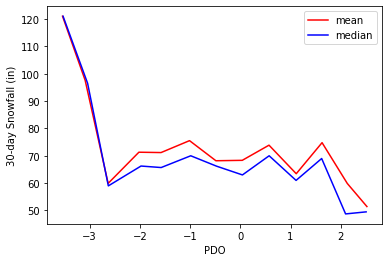

In [44]:
# PDO is a metric that is measured every 30 days, so I wonder if the 30-day looks a little different
plt.plot(win_pdom['PDO'], win_pdom['SNOW30'], color='red', label='mean')
plt.plot(win_pdo['PDO'], win_pdo['SNOW30'], color='blue', label='median')
plt.xlabel('PDO')
plt.ylabel('30-day Snowfall (in)')
plt.legend()
plt.show()

The snowfall looks fairly consistent with PDO, except for when PDO gets strongly negative. This may just be a couple of outliers here, but I would like to find out.

In [46]:
win[win['PDO'] < -2.9]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,PDOb
1134,1949-02-02,0.12,2.5,93.0,20.0,-1.000000,1.000000,02,02,-2.933226,0.156065,12.5,67.5,116.5,"(-3.462, -2.923]"
1135,1949-02-03,0.15,4.0,95.0,11.0,-1.000000,8.000000,02,03,-2.984516,0.156290,13.5,65.5,120.5,"(-3.462, -2.923]"
1136,1949-02-04,0.71,6.0,96.0,14.0,0.000000,10.000000,02,04,-3.035806,0.156516,19.5,71.5,126.5,"(-3.462, -2.923]"
1137,1949-02-05,0.00,0.0,96.0,13.0,-3.000000,-3.000000,02,05,-3.087097,0.156742,19.5,42.5,126.5,"(-3.462, -2.923]"
1138,1949-02-06,0.00,0.0,94.0,16.0,-11.000000,14.000000,02,06,-3.138387,0.156968,14.5,22.5,126.5,"(-3.462, -2.923]"
1139,1949-02-07,0.88,10.0,100.0,18.0,2.000000,2.000000,02,07,-3.189677,0.157194,22.5,32.5,134.5,"(-3.462, -2.923]"
1140,1949-02-08,0.00,0.0,100.0,7.0,-1.000000,4.000000,02,08,-3.240968,0.157419,22.5,32.5,126.5,"(-3.462, -2.923]"
1141,1949-02-09,0.53,8.0,102.0,16.0,3.000000,14.000000,02,09,-3.292258,0.157645,28.0,40.5,130.5,"(-3.462, -2.923]"
1142,1949-02-10,0.00,0.0,99.0,30.0,8.000000,29.000000,02,10,-3.343548,0.157871,24.0,37.5,123.5,"(-3.462, -2.923]"
1143,1949-02-11,0.89,6.0,100.0,29.0,20.000000,21.000000,02,11,-3.394839,0.158097,24.0,43.5,127.5,"(-3.462, -2.923]"


There were only 3 times the PDO went below 2.9; both the 30-day and 14-day snowfalls went well above normal during those times (at least those times that occurred after November 15th). The PDO hasn't gone that far negative since 1955.

Now, to look at AMO

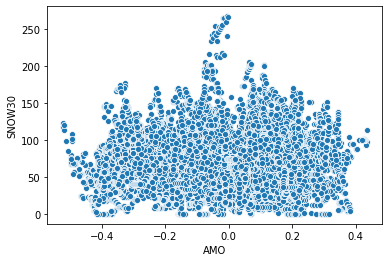

In [48]:
sns.scatterplot(win_p['AMO'], win_p['SNOW30'])
plt.show()

Higher values appear to be clustered more around and just below 0. Let's see if we can group these together to look for trends in the median or mean.

In [49]:
buckets = np.linspace(-0.55, 0.5, 20)
win['AMOb'] = pd.cut(win['AMO'], buckets)

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
win_amo = win.groupby(['AMOb']).median()
win_amo

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
AMOb,,,,,,,,,,,
"(-0.6, -0.542]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(-0.542, -0.484]",0.0,0.0,115.0,38.50,16.500000,24.0,-0.636452,-0.496758,22.50,48.00,89.50
"(-0.484, -0.426]",0.0,0.0,75.0,38.00,18.000000,24.0,-0.777419,-0.439484,8.00,22.00,43.90
"(-0.426, -0.368]",0.0,0.0,27.5,36.00,19.000000,24.0,0.024333,-0.391689,8.80,22.20,50.70
"(-0.368, -0.311]",0.0,0.0,56.0,32.00,16.000000,22.0,-0.143226,-0.335667,15.00,36.00,76.50
"(-0.311, -0.253]",0.0,0.0,65.0,33.00,17.000000,25.0,0.452581,-0.288355,15.00,33.00,70.00
"(-0.253, -0.195]",0.0,0.0,57.0,34.50,18.500000,25.0,-0.195833,-0.219871,14.00,28.00,66.00
"(-0.195, -0.137]",0.0,0.0,65.0,34.00,18.000000,26.0,-0.317392,-0.166016,13.00,33.00,70.00
"(-0.137, -0.0789]",0.0,0.0,70.5,35.00,19.000000,26.0,0.346121,-0.099617,13.00,30.00,65.15


In [51]:
# let's do the same for the average
win_amo_avg = win.groupby(['AMOb']).mean()

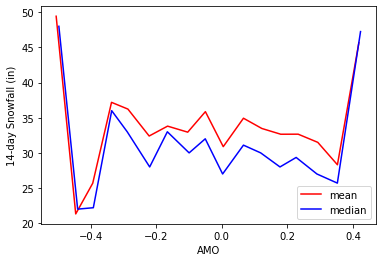

In [52]:
# let's plot the 14-day snowfall for the median and mean
plt.plot(win_amo_avg['AMO'], win_amo_avg['SNOW14'], color='red', label='mean')
plt.plot(win_amo['AMO'], win_amo['SNOW14'], color='blue', label='median')
plt.xlabel('AMO')
plt.ylabel('14-day Snowfall (in)')
plt.legend()
plt.show()

Very interesting that the snowfall also shows up at the extremes. Let's look at the 30-day total too.

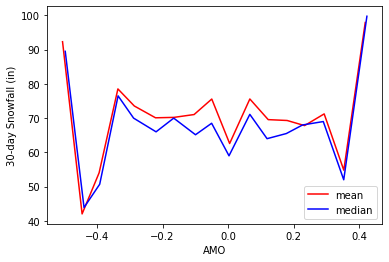

In [53]:
# let's plot the 14-day snowfall for the median and mean
plt.plot(win_amo_avg['AMO'], win_amo_avg['SNOW30'], color='red', label='mean')
plt.plot(win_amo['AMO'], win_amo['SNOW30'], color='blue', label='median')
plt.xlabel('AMO')
plt.ylabel('30-day Snowfall (in)')
plt.legend()
plt.show()

similar effect. Let's see how many points are that far to the extremes.

In [54]:
win[win['AMO'] < -0.484]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,PDOb,AMOb
6109,1974-04-05,0.00,0.0,106.0,31.0,8.0,19.000000,04,05,-0.642581,-0.487645,4.380000e+01,56.8,67.8,"(-0.769, -0.231]","(-0.542, -0.484]"
6110,1974-04-06,0.13,1.1,106.0,50.0,19.0,26.000000,04,06,-0.630323,-0.491581,4.390000e+01,53.9,68.9,"(-0.769, -0.231]","(-0.542, -0.484]"
6111,1974-04-07,0.43,5.1,110.0,31.0,18.0,21.000000,04,07,-0.618065,-0.495516,4.120000e+01,59.0,74.0,"(-0.769, -0.231]","(-0.542, -0.484]"
6112,1974-04-08,0.00,0.0,108.0,43.0,17.0,24.000000,04,08,-0.605806,-0.499452,4.120000e+01,59.0,74.0,"(-0.769, -0.231]","(-0.542, -0.484]"
6113,1974-04-09,0.00,0.0,106.0,52.0,24.0,38.000000,04,09,-0.593548,-0.503387,2.660000e+01,59.0,74.0,"(-0.769, -0.231]","(-0.542, -0.484]"
6114,1974-04-10,1.73,15.7,120.0,44.0,15.0,17.000000,04,10,-0.581290,-0.507323,2.780000e+01,67.7,85.7,"(-0.769, -0.231]","(-0.542, -0.484]"
6115,1974-04-11,1.75,13.0,130.0,28.0,10.0,13.000000,04,11,-0.569032,-0.511258,3.490000e+01,80.7,98.7,"(-0.769, -0.231]","(-0.542, -0.484]"
6116,1974-04-12,0.84,7.9,134.0,31.0,13.0,21.000000,04,12,-0.556774,-0.515194,4.280000e+01,86.6,106.6,"(-0.769, -0.231]","(-0.542, -0.484]"
6117,1974-04-13,1.34,11.8,143.0,21.0,11.0,16.000000,04,13,-0.544516,-0.519129,5.350000e+01,97.4,118.4,"(-0.769, -0.231]","(-0.542, -0.484]"
6118,1974-04-14,0.00,0.0,140.0,31.0,14.0,14.000000,04,14,-0.532258,-0.523065,4.840000e+01,89.6,117.4,"(-0.769, -0.231]","(-0.542, -0.484]"


Looks like it was only that far negative in April of '74 and March of '76. Let's see the high side too.

In [56]:
win[win['AMO'] > 0.384]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,PDOb,AMOb
2524,1955-11-15,0.00,6.0,34.0,15.00,-6.00,-4.000000,11,15,-3.080000,0.385000,4.300000e+01,47.5,76.5,"(-3.462, -2.923]","(0.384, 0.442]"
18206,2010-04-08,0.00,0.0,105.0,38.00,13.00,38.000000,04,08,0.700667,0.386800,6.200000e+01,83.5,94.5,"(0.308, 0.846]","(0.384, 0.442]"
18207,2010-04-09,0.00,0.0,101.0,38.00,13.00,29.000000,04,09,0.712000,0.391400,5.400000e+01,83.0,94.5,"(0.308, 0.846]","(0.384, 0.442]"
18208,2010-04-10,0.00,0.0,92.0,45.00,18.00,42.000000,04,10,0.723333,0.396000,5.000000e+01,76.0,92.5,"(0.308, 0.846]","(0.384, 0.442]"
18209,2010-04-11,0.00,0.0,91.0,49.00,38.00,46.000000,04,11,0.734667,0.400600,4.200000e+01,76.0,88.5,"(0.308, 0.846]","(0.384, 0.442]"
18210,2010-04-12,0.00,0.0,91.0,46.00,29.00,29.000000,04,12,0.746000,0.405200,3.500000e+01,76.0,88.5,"(0.308, 0.846]","(0.384, 0.442]"
18211,2010-04-13,1.24,12.0,106.0,30.00,22.00,28.000000,04,13,0.757333,0.409800,1.500000e+01,88.0,100.5,"(0.308, 0.846]","(0.384, 0.442]"
18212,2010-04-14,0.00,0.0,94.0,44.00,16.00,42.000000,04,14,0.768667,0.414400,1.200000e+01,88.0,100.5,"(0.308, 0.846]","(0.384, 0.442]"
18213,2010-04-15,0.00,0.0,87.0,55.00,9.00,51.000000,04,15,0.780000,0.419000,1.200000e+01,74.0,100.5,"(0.308, 0.846]","(0.384, 0.442]"
18214,2010-04-16,0.00,0.0,83.0,56.00,36.00,44.000000,04,16,0.774667,0.420133,1.200000e+01,66.0,100.5,"(0.308, 0.846]","(0.384, 0.442]"


Just 1 day in 1955 has an AMO that high The rest of the data points are from April of 2010. <br>
Both the high and low values have strong snowfall, but they are far out on the extremes with few data points to back that up. I wonder if there is any relation between the ratio of AMO and PDO to the snowfall. Let's see.

In [72]:
# Let's scale the ratio first - DID NOT GET THIS TO WORK
# min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,10))
# win_sc = min_max_scaler.fit_transform([win['PDO'], win['AMO']])
# win_sc
#win['ratio'] = win['PDO']/win['AMO']

array([[ 1.,  1.,  1., ..., nan, nan, nan],
       [10., 10., 10., ...,  1.,  1.,  1.]])

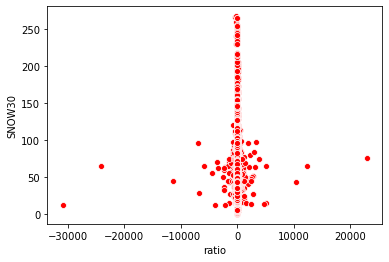

In [58]:
sns.scatterplot(win['ratio'], win['SNOW30'], color='red')

Since these ratios have a lot of values around 0, that creates anomolies that make this graph hard to look at. I'm going to try the difference in normalized values instead.

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


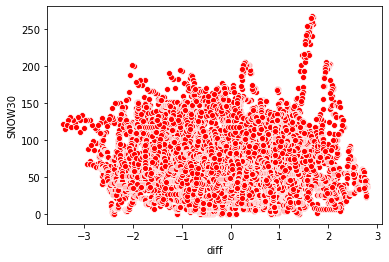

In [60]:
win['diff'] = win['PDO'] + win['AMO']
sns.scatterplot(win['diff'], win['SNOW30'], color='red')

Snowfall looks a little higher as we get away from 0; let's see the absolute difference.

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


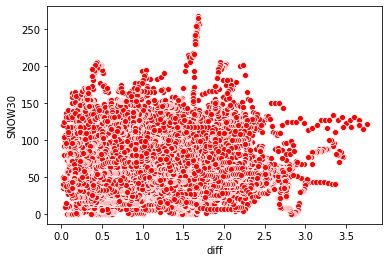

In [62]:
win['diff'] = abs(win['PDO']) + abs(win['AMO'])
sns.scatterplot(win['diff'], win['SNOW30'], color='red')

These plots were OK, but I need to scale so that PDO doesn't dominate. 